# Movie Studio Analysis

<img src="images/banner.png/" style="height:400px">

# Business Understanding

Our company has decided to create a **new movie studio**. This is a new venture for the company and our first introduction to the film industry. I will be exploring what types of films are currently doing the best at the box office. My focus will be to make suggestions for the first film we will produce to make it as successful as possible. I will be focusing on **movie profit** to determine the success of a movie, which will be calculated by deducting the movie budget from the worldwide gross.

In order to help decide what types of films to create, I investigate the following 3 business questions:
1. What **genre** movie would produce the greatest profits?
2. What **director** would produce the greatest profits?
3. Which **release month** would produce the greatest profits?

# Data Understanding

I will be using 2 datasets in this notebook.
1. **tn.movie_budgets.csv.gz**: This is a datset from [The Numbers](https://www.the-numbers.com/) containing release date, production budget, domestic gross and worldwide gross for 5,782 movies. I use this dataset to determine the most profitable movies and to analyze the release month of the movies.
2. **im.db**: This is a database from [IMDB](https://www.IMDB.com) containing 8 tables. I chose 3 tables to use - *movie_basics*, *directors*, and *persons*.  `movie_basics` has basic movie information for 146,144 movies. `directors` has 140,417 entries of movie id's matched to person id's. `persons` has 606,648 people related to the movies with their birth year, death year, and primary professions. I use this dataset to determine the director and genre that will result in the most profitable movie.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns

%matplotlib inline

pd.options.mode.copy_on_write = True

# Suppress harmless warning for use_inf_as_na
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# Save The Numbers dataset to budget_df
budget_df = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

In [3]:
# Save IMDB dataset to conn
conn = sqlite3.connect('data/zippedData/im.db')

# Save movie_basics table as a Pandas dataframe movie_basics_df
query_movie_basics = """

SELECT *
  FROM movie_basics
"""

movie_basics_df = pd.read_sql(query_movie_basics, conn)

# Save directors table as a Pandas dataframe directors_df
query_directors = """

  SELECT *
    FROM directors
GROUP BY movie_id
"""

directors_df = pd.read_sql(query_directors, conn)


# Save persons table as a Pandas dataframe persons_df
query_persons = """

SELECT *
  FROM persons
"""

persons_df = pd.read_sql(query_persons, conn)

## Data Preparation

I take a closer look at each dataset in this section. For each dataframe, I use `.head()` to preview the first 5 entries. This gives me a brief overview of what is included in the dataset and the format of it. I then use `.info()` to dig deeper, viewing column names, number of nulls, and datatypes of each column. This begins to give me an idea on how I will need to clean and work with each of the datasets.

### The Numbers

In [4]:
# Preview first 5 entries of budget_df
budget_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [5]:
# View the overall shape, dtypes and null counts for each column in bom_df
budget_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


There are no nulls in this dataset. I will be creating a profit column to indicate the difference between `production_budget` and `worldwide_gross`. I also will create a separate column for month of release in order to determine the most profitable release month.

### IMDB

In [6]:
# Preview first 5 entries of movie_basics_df
movie_basics_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [7]:
# Check for duplicates in movie_basics_df
movie_basics_df[movie_basics_df.duplicated(subset='movie_id')]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres


In [8]:
# View the overall shape, dtypes and null counts for each column in movie_basics_df
movie_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [9]:
# Preview what is listed under the null genre entries
movie_basics_df[movie_basics_df['genres'].isna()]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
16,tt0187902,How Huang Fei-hong Rescued the Orphan from the...,How Huang Fei-hong Rescued the Orphan from the...,2011,NaN,None
22,tt0253093,Gangavataran,Gangavataran,2018,134.0,None
35,tt0306058,Second Coming,Second Coming,2012,95.0,None
40,tt0326592,The Overnight,The Overnight,2010,88.0,None
44,tt0330811,Regret Not Speaking,Regret Not Speaking,2011,NaN,None
...,...,...,...,...,...,...
146088,tt9907396,Footloose in the Cotswolds - Part 1,Footloose in the Cotswolds - Part 1,2016,118.0,None
146089,tt9907608,Footloose in the Cotswolds - Part 2,Footloose in the Cotswolds - Part 2,2016,102.0,None
146107,tt9910922,Doctor Who Augmented Reality: Times Magazine,Doctor Who Augmented Reality: Times Magazine,2013,NaN,None
146129,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None


There are no null entries in the `movie_id` and `primary_title` columns. There are 5,408 nulls in the genres column. I am using this table specifically for genres, so I will be dropping the columns where the genre is null. With 146,144 entries, I can afford to drop all of the nulls.

In [10]:
# Preview first 5 entries of directors_df
directors_df.head()

,movie_id,person_id
0,tt0063540,nm0712540
1,tt0066787,nm0002411
2,tt0069049,nm0000080
3,tt0069204,nm0611531
4,tt0100275,nm0765384


In [11]:
# View the overall shape, dtypes and null counts for each column in directors_df
directors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140417 entries, 0 to 140416
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   140417 non-null  object
 1   person_id  140417 non-null  object
dtypes: object(2)
memory usage: 2.1+ MB


In [12]:
# Check for duplicates in directors_df
directors_df[directors_df.duplicated(subset='movie_id')]

,movie_id,person_id


There are no nulls in `directors_df`. I will be using this table to connect the `movie_id` from `movie_basics_df` to the `person_id` from `persons_df` in order to display the name of the directors for each movie.

In [13]:
# Preview first 5 entries of persons_df
persons_df.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [14]:
# View the overall shape, dtypes and null counts for each column in persons_df
persons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


I am using only `person_id` and `primary_name` from this table, which neither have nulls. I will be using this to connect the director name to the movie name. I don't need to handle any nulls here.

In [15]:
# Check for duplicates in persons_df
persons_df[persons_df.duplicated(subset='person_id')].head()

,person_id,primary_name,birth_year,death_year,primary_profession


## Data Cleaning

After completing an overview of each of the datasets, I clean the data to prepare it for analysis. I then use SQL Query to merge the two cleaned dataframes.

### The Numbers

In order to clean `budget_df`, I complete the following steps:
1. I must convert columns `production_budget`,  `domestic_gross` and `worldwide_gross` to type *int* in order to use aggregate functions.
2. I then create a `profit` column, which takes the `worldwide_gross` column minus the `production_budget` column. This will help me determine success of a movie.
3. Then I create a `release_month` column that takes just the month in the `release_date` column. This will help me determine the most successful month to release a movie.

In [16]:
# Remove $ and commas from dollar values
budget_df['production_budget'] = budget_df['production_budget'].map(lambda x: str(x).replace(',','').replace('$',''))
budget_df['domestic_gross'] = budget_df['domestic_gross'].map(lambda x: str(x).replace(',','').replace('$',''))
budget_df['worldwide_gross'] = budget_df['worldwide_gross'].map(lambda x: str(x).replace(',','').replace('$',''))


# Convert 'production_budget', 'domestic_gross', and 'worldwide_gross' to int
budget_df['production_budget'] = budget_df['production_budget'].astype('int')
budget_df['domestic_gross'] = budget_df['domestic_gross'].astype('int')
budget_df['worldwide_gross'] = budget_df['worldwide_gross'].astype('int')

In [17]:
# Create 'profit' column by subtracting 'production_budget' from 'worldwide_gross'
budget_df['profit'] = budget_df['worldwide_gross'] - budget_df['production_budget']

In [18]:
# Create 'release_month' column by taking month from 'release_date' column
budget_df['release_month'] = budget_df['release_date'].map(lambda x: x[0:3])

In [19]:
# Preview changes
budget_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,release_month
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,May
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,Dec
...,...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,7000,0,0,-7000,Dec
5778,79,"Apr 2, 1999",Following,6000,48482,240495,234495,Apr
5779,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,-3662,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,-1400,Sep


### IMDB

In order to clean the IMDB data, I join the three tables - *movie_basics*, *directors*, and *persons* - into one table and save it as `imdb_df`. Here are the steps I took to join them:
- Take primary_title from *movie_basics* and label it as **Movie_Title**.
- Take genres from *movie_basics*, add a space after each comma, and label it as **Genres**.
- Take primary_name from *persons*, list all distinct names, separate with a space and comma, and label it as **Directors**
- Connect *movie_basics* table to *directors* table using movie_id
- Connect *directors* table to *persons* table using person_id
- Group the data by *movie_id*

In [20]:
# Join the three tables into one dataframe
# Add all directors for one movie on the same line seperated by a comma and a space

query_imdb = """

SELECT mb.primary_title AS Movie_Title, replace(mb.genres, ',', ', ') AS Genres, replace(GROUP_CONCAT(DISTINCT p.primary_name),',', ', ') AS Directors
  FROM movie_basics AS mb
  JOIN directors AS d
 USING (movie_id)
  JOIN persons AS p
 USING (person_id)
GROUP BY movie_id

"""

imdb_df = pd.read_sql(query_imdb, conn)

imdb_df.sample(20)


,Movie_Title,Genres,Directors
54441,Adhisaya Ulagam,"Adventure, Sci-Fi",Shakthi Scott
132829,The Fun's Not Over,Documentary,Michael Cross
97184,Sleep No More,Horror,Phillip Guzman
109997,A Way Out Documentary,Documentary,Gladys Bensimon
1471,Rakshasudu,"Action, Crime, Thriller",Ramesh Varma
66122,The Last Formula,Documentary,Geoff Byrd
67060,Héroe Corriente,Documentary,Miguel Monforte
22562,Manyaa the Wonder Boy,"Family, Musical, Sport",Sangramsinh Gaikwad
1952,Model Fight,"Action, Adventure, Horror",Kelcey Coe
133100,The Right Bus,Romance,Robbie Moffat


In [21]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140416 entries, 0 to 140415
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Movie_Title  140416 non-null  object
 1   Genres       137238 non-null  object
 2   Directors    140416 non-null  object
dtypes: object(3)
memory usage: 3.2+ MB


### Merge Datasets

I will now merge `budget_df` to `imdb_df` in order to analyze the data. These are the steps I will take to merge the two dataframes:
- Select *Movie_Title*, *Genres*, and *Directors* from `imdb_df`.
- Select *release_month* and *profit* from `budget_df`.
- Inner join the two dataframes using *movie* from `budget_df` and *Movie_Title* from `imdb_df`.

Once the tables are joined, I will standardize the column names so that they are all title case. I will then set the *Release_Month* column to have have an order - they will be ordered by month according to the calendar year. 

In [22]:
# Use SQL query to merge the two dataframes
from pandasql import sqldf
pysqldf = lambda q: sqldf(q,globals())
q = """
SELECT imdb.Movie_Title, imdb.Genres, imdb.Directors, budget.release_month, budget.profit
FROM imdb_df AS imdb
JOIN budget_df AS budget
  ON budget.movie = imdb.Movie_Title
"""

movies_data = pysqldf(q)

In [23]:
# Standardize column names
movies_data.columns = movies_data.columns.map(lambda x: x.title())

In [24]:
# Order months in Release_Month column by calendar year
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
movies_data['Release_Month'] = pd.Categorical(movies_data['Release_Month'], categories=months, ordered=True)

In [25]:
movies_data['Release_Month'].value_counts()

Release_Month
Dec    488
Oct    352
Apr    342
Mar    329
Sep    327
Jun    312
Aug    300
Nov    286
Feb    261
Jul    251
May    245
Jan    234
Name: count, dtype: int64

In [26]:
# View overview of columns and data in movies_data
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3727 entries, 0 to 3726
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Movie_Title    3727 non-null   object  
 1   Genres         3690 non-null   object  
 2   Directors      3727 non-null   object  
 3   Release_Month  3727 non-null   category
 4   Profit         3727 non-null   int64   
dtypes: category(1), int64(1), object(3)
memory usage: 120.6+ KB


In [27]:
# Preview first 5 lines of movies_data
movies_data.head()

,Movie_Title,Genres,Directors,Release_Month,Profit
0,Foodfight!,"Action, Animation, Comedy",Lawrence Kasanoff,Dec,-44926294
1,Mortal Kombat,"Action, Adventure, Fantasy",Simon McQuoid,Aug,102133227
2,The Overnight,None,Jed I. Goodman,Jun,965996
3,On the Road,"Adventure, Drama, Romance",Walter Salles,Mar,-15686698
4,The Secret Life of Walter Mitty,"Adventure, Comedy, Drama",Ben Stiller,Dec,96861183


# Exploratory Data Analysis

In this section, I will analyze the data in order to answer the business questions. Using *profit* as a mark of success, I will determine the *genre*, *director* and *release month* of the most successful movies.

In [28]:
# Set theme for graphs
sns.set_theme(context='notebook', style='whitegrid', palette='husl')

### Movie Profits By *Genre*

Below, I create a new dataframe, `df_genres` from the `movies_data` dataframe. I separate the genres so that they each have their own row. This is because some movies are listed with multiple genres and I want all of them to be accounted for. I then group `df_genres` by the mean profit for each genre and save it as `profits_by_genre`. Once `profits_by_genre` is sorted by greatest profits, I graph a barplot of the data to display the the mean movie profits by genre in descending order. Genres are on the x-axis and profits are on the y-axis. Lastly, I display the `profits_by_genre` dataframe in order to list all of the profits by genre clearly. This is listed in descending order. **Animation movies** have the **greatest mean profit** at $219,399,378.

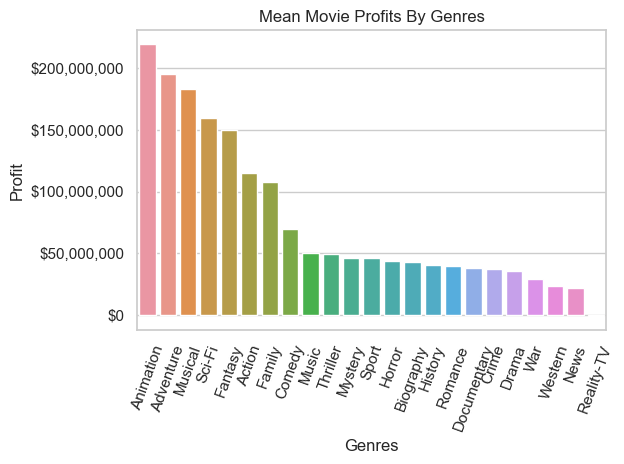

In [29]:
# Split the "Genres" column into multiple rows, so each genre has its own row
df_genres = movies_data.assign(Genre=movies_data['Genres'].str.split(', ')).explode('Genre')

# Group by genre and mean the profits
profits_by_genre = df_genres.groupby('Genre')['Profit'].mean()

# Sort genres descending by greatest profits
profits_by_genre = profits_by_genre.reset_index().sort_values(by='Profit', ascending=False)

# Plot profits_by_genre
ax = sns.barplot(data=profits_by_genre, x='Genre', y='Profit')

# Set axes labels, title, and rotate x ticks
ax.set(xlabel='Genres', ylabel='Profit', title='Mean Movie Profits By Genres')
plt.xticks(rotation=70)

# Disable scientific notation on the y-axis
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='plain', axis='y')

# Define a function to format profit values as currency
def format_currency(x, pos):
    return '${:,.0f}'.format(x)

# Apply currency formatting to the y-axis ticks
ax.yaxis.set_major_formatter(FuncFormatter(format_currency))

plt.tight_layout();

In [30]:
# Convert format of Profit column to currency
profits_by_genre['Profit'] = profits_by_genre['Profit'].map('${:,.0f}'.format)
profits_by_genre

,Genre,Profit
2,Animation,"$219,399,378"
1,Adventure,"$195,505,863"
13,Musical,"$182,732,306"
18,Sci-Fi,"$159,556,465"
9,Fantasy,"$149,960,913"
0,Action,"$115,227,192"
8,Family,"$107,620,185"
4,Comedy,"$69,573,286"
12,Music,"$50,128,439"
20,Thriller,"$49,454,764"


### Movie Profits By *Director*

Below, I create a new dataframe, `df_directors` from the `movies_data` dataframe. I separate the directors so that they each have their own row. This is because some movies are listed with multiple directors and I want all of them to be accounted for. I then group `df_directors` by the sum of profits for each director and save it as `profits_by_director`. I sort `profits_by_director` in descending order by greatest profits and save the top 10 as `top_ten_directors`. I graph a barplot of the data to display the the total movie profits by top 10 directors in descending order. Directors are on the x-axis and profits are on the y-axis. Lastly, I display the `top_ten_directors` dataframe in order to list all of the profits by director clearly. This is listed in descending order. **Pierre Coffin** has the **greatest profit** at $3,419,745,331.

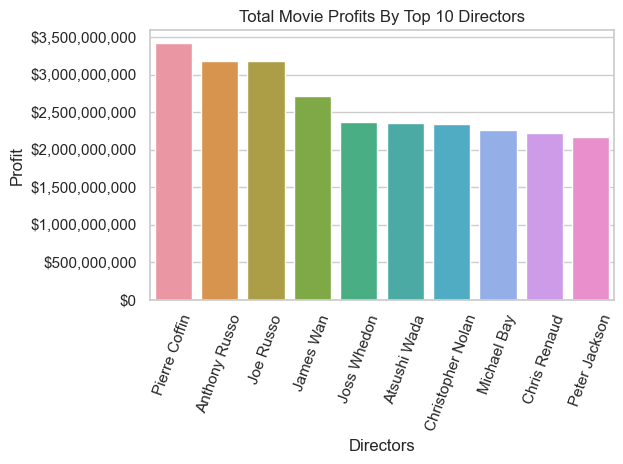

In [31]:
# Split the "Directors" column into multiple rows, so each director has their own row
df_directors = movies_data.assign(Director=movies_data['Directors'].str.split(', ')).explode('Director')

# Group by director and sum the profits
profits_by_director = df_directors.groupby('Director')['Profit'].sum()

# Create df of top 10 directors based on greatest profits
top_ten_directors = profits_by_director.reset_index().sort_values(by='Profit', ascending=False)[0:10]

# Plot profits_by_director
ax = sns.barplot(data=top_ten_directors, x='Director', y='Profit')

# Set axes labels, title, and rotate x ticks
ax.set(xlabel='Directors', ylabel='Profit', title='Total Movie Profits By Top 10 Directors')
plt.xticks(rotation=70)

# Disable scientific notation on the y-axis
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='plain', axis='y')

# Apply currency formatting to the y-axis ticks
ax.yaxis.set_major_formatter(FuncFormatter(format_currency))

plt.tight_layout();

In [32]:
# Convert format of Profit column to currency
top_ten_directors['Profit'] = top_ten_directors['Profit'].map('${:,.0f}'.format)
top_ten_directors

,Director,Profit
2353,Pierre Coffin,"$3,419,745,331"
222,Anthony Russo,"$3,182,605,502"
1384,Joe Russo,"$3,182,605,502"
1233,James Wan,"$2,711,988,461"
1533,Joss Whedon,"$2,368,484,614"
261,Atsushi Wada,"$2,351,345,279"
560,Christopher Nolan,"$2,336,180,484"
1995,Michael Bay,"$2,263,998,250"
518,Chris Renaud,"$2,218,783,438"
2329,Peter Jackson,"$2,172,948,044"


In [33]:
# What genre of movies does Pierre Coffin make?
df_directors[df_directors['Director'] == 'Pierre Coffin']

,Movie_Title,Genres,Directors,Release_Month,Profit,Director
460,Despicable Me,"Animation, Comedy, Family","Chris Renaud, Pierre Coffin",Jul,474464573,Pierre Coffin
909,Despicable Me 2,"Adventure, Animation, Comedy","Chris Renaud, Pierre Coffin",Jul,899216835,Pierre Coffin
1605,Minions,"Adventure, Animation, Comedy","Kyle Balda, Pierre Coffin",Jul,1086336173,Pierre Coffin
2260,Despicable Me 3,"Adventure, Animation, Comedy","Kyle Balda, Pierre Coffin, Eric Guillon",Jun,959727750,Pierre Coffin


### Movie Profits By *Release Month*

Below, I create a new dataframe, `profits_by_month` from the `movies_data` dataframe. I group the data by the mean profit for each release month. I then graph this data on a line plot. Release months are on the x-axis and profits are on the y-axis. Lastly, I display the `profits_by_month` dataframe in order to list all of the profits by release month clearly. This is listed in order of calendar month. **June** has the **greatest mean profit** at $101,567,182.

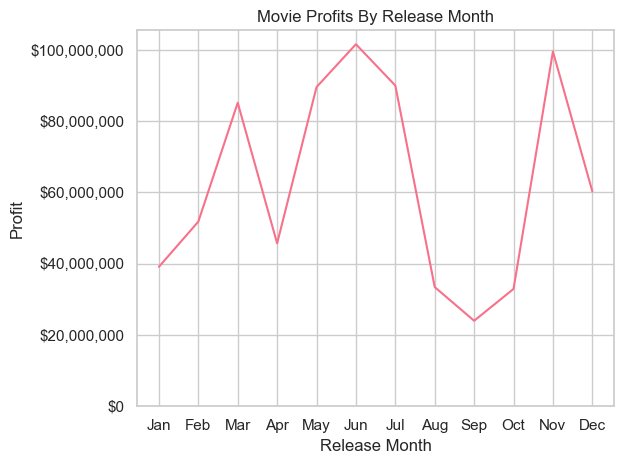

In [34]:
# Group by release month and sum the profits
profits_by_month = movies_data.groupby('Release_Month')['Profit'].mean()

# Reset index
profits_by_month = profits_by_month.reset_index()

ax = sns.lineplot(data=profits_by_month, x='Release_Month', y='Profit')

# Set axes labels, title, and rotate x ticks
ax.set(xlabel='Release Month', ylabel='Profit', title='Movie Profits By Release Month')

# Disable scientific notation on the y-axis
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.ticklabel_format(style='plain', axis='y')

# Apply currency formatting to the y-axis ticks
ax.yaxis.set_major_formatter(FuncFormatter(format_currency))

# Set the lower limit of the y-axis to 0
ax.set_ylim(0)

plt.tight_layout();

In [35]:
# Convert format of Profit column to currency
profits_by_month['Profit'] = profits_by_month['Profit'].map('${:,.0f}'.format)
profits_by_month

,Release_Month,Profit
0,Jan,"$39,121,806"
1,Feb,"$51,798,111"
2,Mar,"$85,155,536"
3,Apr,"$45,705,193"
4,May,"$89,545,564"
5,Jun,"$101,567,182"
6,Jul,"$89,979,279"
7,Aug,"$33,440,510"
8,Sep,"$23,983,721"
9,Oct,"$32,917,968"


# Conclusions

## Limitations

There are various limitations in this analysis.

1. The **datasets** had to be **greatly cut down**. IMDB started with over 140,000 movies, but since there was not profit information for this data, our final dataset ended up being just 3,727 movies to make sure each movie had profit, genre and director information.
2. There are many factors that contribute to the success of a movie and the profits earned. This analysis solely considers genre, director, and release month. While I focus on these factors, a number of **other factors can be contributing to the profit numbers**.

## Recommendations

This analysis has led me to conclude the following three recommendations:

1. The **genre** of the first movie produced should be **animation**. Animation movies return the greatest profits at an average of $219,399,378.
   
2. The **director** of the first movie produced should be **Pierre Coffin**. He has returned the greatest profits at $3,419,745,331.
   
3. The **release month** of the first movie produced should be **June**. This month returns the greatest profits at an average of $101,567,182.

## Next Steps

Additional analysis could further optimize our profits for the acquisition of a new movie studio. I would like to investigate the following factors 
1. Analyze **budgets against profits** to determine a sweet spot for the budget for the first film. Consider costs to make film, marketing costs, and cast and staff salaries.
2. Consider the profit opportunities between **theater releases** and **streaming services**. Should this first movie be released in theaters, over streaming services, or both?
3. Determine an appropriate **runtime length** of the movie that would contribute to the success of the film. We do not want a film that is too short or too long. What runtime lengths are most successful?